# Assessmet of key metrics in 1/20th degree MOM6 experiment: Time series

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter
import matplotlib.ticker as mticker

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44257/status,
Dashboard: /proxy/44257/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42817,Workers: 8
Dashboard: /proxy/44257/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:34887,Total threads: 6
Dashboard: /proxy/39545/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:32887,


## Load data

In [26]:
session = cc.database.create_session()
session_005 = cc.database.create_session(
    'panan_005deg_jra55_ryf.db')
path_output_SWMT = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
start_time = '1991-01-01'
end_time = '1995-12-31'

In [5]:
exptdict = OrderedDict([
    ('pa_z_v13', # 1/10th panantarctic zstar run with ACCESS-OM2-01 year 200 IC + BF
     {'expt': 'panant-01-zstar-v13'}),
    ('pa_z_yr2', # 1/10th panantarctic zstar run with ACCESS-OM2-01 year 2 IC + BF
     {'expt': 'panant-01-zstar-ACCESSyr2'}),
    ('pa_z_005', # 1/20th panantarctic zstar run with ACCESS-OM2-01 year 2 IC + BF
     {'expt': 'panan_005deg_jra55_ryf'})
])

In [6]:
DSW_region = {
'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
'lon': [[-60, -35, -48, -62, -60],
        [48, 73, 74, 48, 48],
        [128-360, 152-360, 152-360, 128-360, 128-360],
        [185-360, 160-360, 164-360, 172-360, 185-360]],
'lat': [[-71, -75, -78, -75, -71],
        [-65, -66.5, -69, -68, -65],
        [-64.5, -66, -69, -67.5, -64.5],
        [-78, -78, -73, -71.5, -78]]}

## Load data

In [24]:
%%time
ekeys = ['pa_z_v13', 'pa_z_yr2', 'pa_z_005']
for ekey in ekeys:
    e = exptdict[ekey]
    if ekey == 'pa_z_005':
        session = session_005
    
    # Kinetic Energy
    e['KE'] = cc.querying.getvar(
        e['expt'], 'KE', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['KE']['Time'] = e['KE'].Time/365 +1
    e['KE'] = e['KE'].sel(Time=slice(start_time, end_time))
    e['KE'] = e['KE'].sum('Layer')
    
    # Global Heat
    e['Heat'] = cc.querying.getvar(
        e['expt'], 'Heat', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['Heat']['Time'] = e['Heat'].Time/365 + 1
    e['Heat'] = e['Heat'].sel(Time=slice(start_time, end_time))
    
    # Global Salt
    e['Salt'] = cc.querying.getvar(
        e['expt'], 'Salt', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['Salt']['Time'] = e['Salt'].Time/365 + 1
    e['Salt'] = e['Salt'].sel(Time=slice(start_time, end_time))
    
    # CFL criteria
    e['CFL'] = cc.querying.getvar(
        e['expt'], 'max_CFL_trans', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['CFL']['Time'] = e['CFL'].Time/365 + 1
    e['CFL'] = e['CFL'].sel(Time=slice(start_time, end_time))
    
    # Sea ice extent
    area = cc.querying.getvar(
        e['expt'], 'areacello', session, n=1,
        chunks={'xh': '200 MB', 'yh': '200 MB'})
    siconc = cc.querying.getvar(
        e['expt'], 'siconc', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'xT': '200 MB', 'yT': '200 MB'}).rename({'yT':'yh', 'xT':'xh'})
    e['siext'] = (siconc*area).sum(['xh', 'yh']).compute()
    
    # Drake Passage transport
    umo_2d = cc.querying.getvar(
        e['expt'], 'umo_2d', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'xq': '200 MB', 'yh': '200 MB'})
    e['DP'] = umo_2d.sel(xq=-71,method='nearest').sel(yh=slice(-82,-50)).sum(
        'yh').compute()/1e9
    
    # Transport stream function
    psi = cc.querying.getvar(
        e['expt'], 'vmo', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'xh': '200MB', 'yq': '200MB'}).sum('xh')
    e['psi'] = (psi.cumsum('rho2_l')-psi.sum('rho2_l'))/1e9
    
    # SWMT in four DSW formation regions
    ds_SWMT = xr.open_mfdataset(
        path_output_SWMT + 'SWMT_in_DSW_region_' + e['expt']  + '*.nc')
    ds_SWMT = ds_SWMT.sel(time=slice(start_time[:4], end_time[:4]))
    e['swmt'] = (
        ds_SWMT.binned_salt_transformation_in_DSW_region +
        ds_SWMT.binned_heat_transformation_in_DSW_region).compute()    
    
    # computed in cell below
    ds_TS = xr.open_dataset(
        path_output_SWMT + 'Abyssal_temp_salinity_' + e['expt'] + '.nc')
    ds_TS = ds_TS.sel(time=slice(start_time, end_time))
    e['T_abyss'] = ds_TS.thetao
    e['S_abyss'] = ds_TS.so

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23317685364544 and this is thread id 23316367677184.
Exception closing connection <sqlite3.Connection object at 0x1533e1da13f0>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-pa

CPU times: user 16.3 s, sys: 1.04 s, total: 17.3 s
Wall time: 28.5 s


## Plots

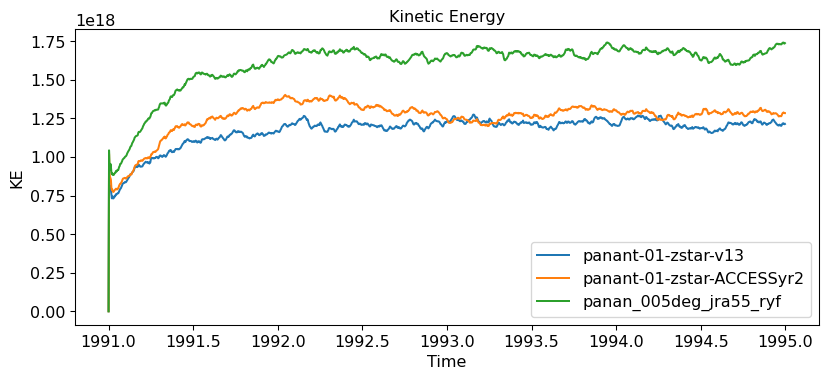

In [8]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['KE'].plot(label=e['expt'])
plt.legend()
plt.title('Kinetic Energy')

plt.show()

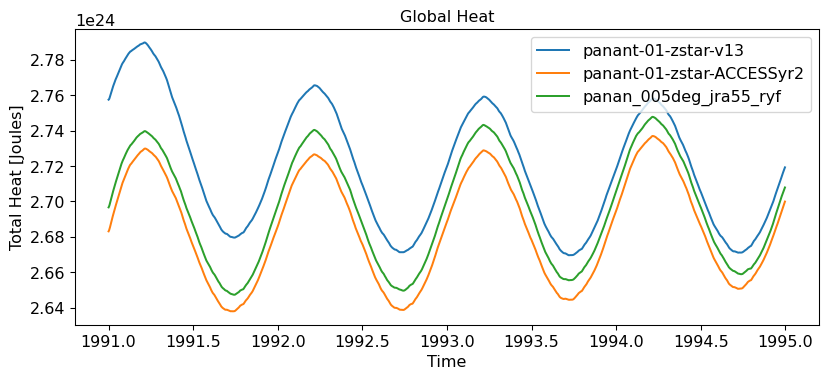

In [9]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['Heat'].plot(label=e['expt'])
plt.legend()
plt.title('Global Heat')

plt.show()

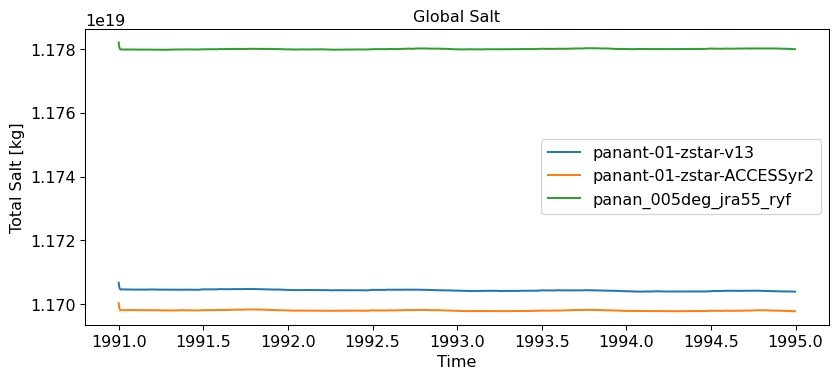

In [10]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['Salt'].plot(label=e['expt'])
plt.legend()
plt.title('Global Salt')

plt.show()

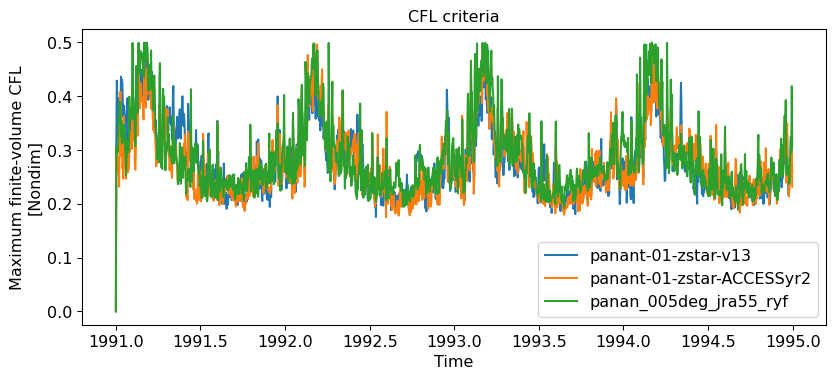

In [11]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['CFL'].plot(label=e['expt'])
plt.legend()
plt.title('CFL criteria')

plt.show()

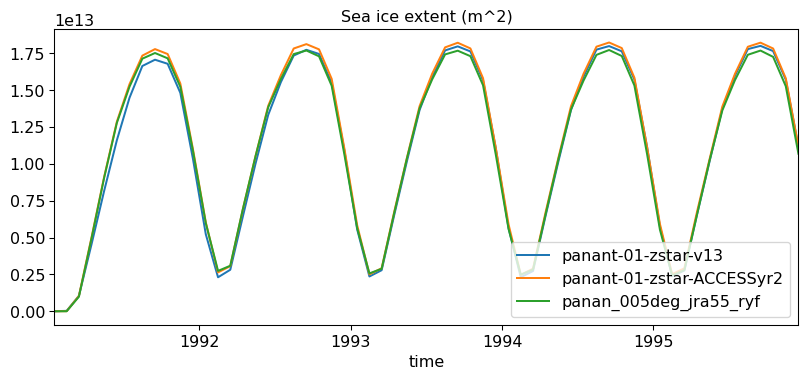

In [12]:
fig = plt.figure(figsize=(10,4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['siext'].plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title(r'Sea ice extent (m^2)')

plt.show()

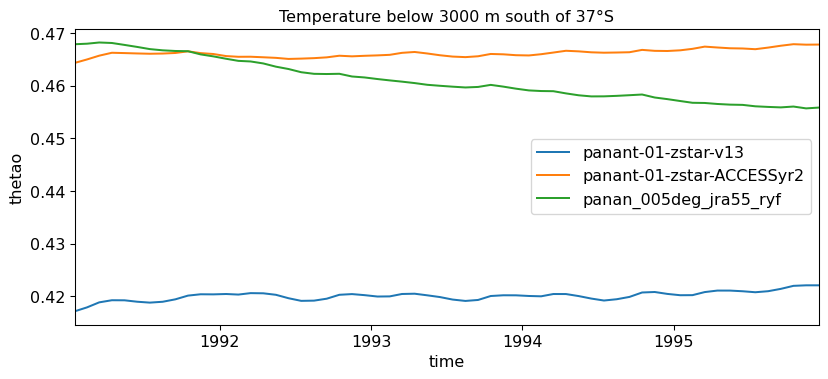

In [13]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['T_abyss'].plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title('Temperature below 3000 m south of 37°S')

plt.show()

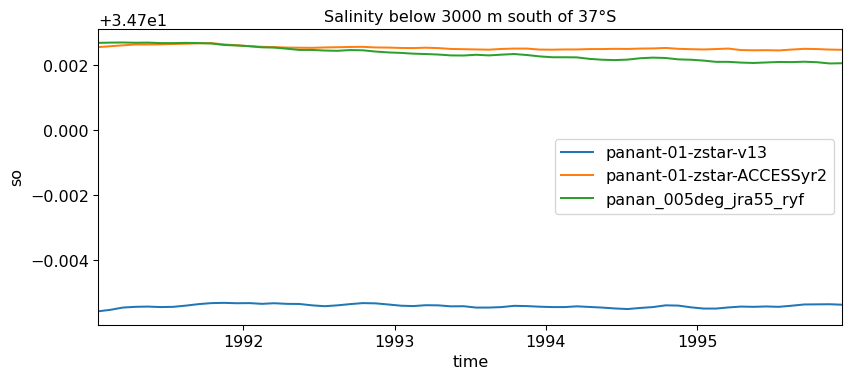

In [20]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['S_abyss'].plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title('Salinity below 3000 m south of 37°S')

plt.show()

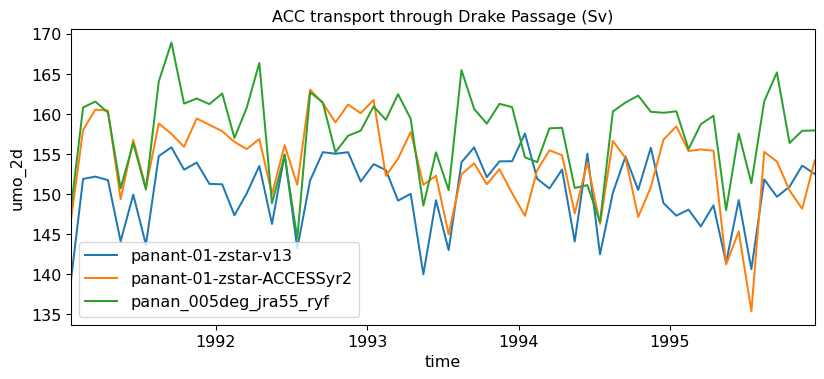

In [14]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['DP'].plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title('ACC transport through Drake Passage (Sv)')

plt.show()

In [15]:
%%time
lat = -60
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt'] + ' done')

panant-01-zstar-v13 done
panant-01-zstar-ACCESSyr2 done
panan_005deg_jra55_ryf done
CPU times: user 14.5 s, sys: 2.02 s, total: 16.5 s
Wall time: 2min 2s


In [16]:
%%time
lat = -40
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt'] + ' done')

panant-01-zstar-v13 done
panant-01-zstar-ACCESSyr2 done
panan_005deg_jra55_ryf done
CPU times: user 10.7 s, sys: 1.3 s, total: 12 s
Wall time: 1min 18s


In [17]:
%%time
lat = -40
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_upper_40S'] = e['psi'].sel(yq=lat, method='nearest').max(
        dim='rho2_l').compute()
    print(e['expt'] + ' done')

panant-01-zstar-v13 done
panant-01-zstar-ACCESSyr2 done
panan_005deg_jra55_ryf done
CPU times: user 7.14 s, sys: 722 ms, total: 7.87 s
Wall time: 40 s


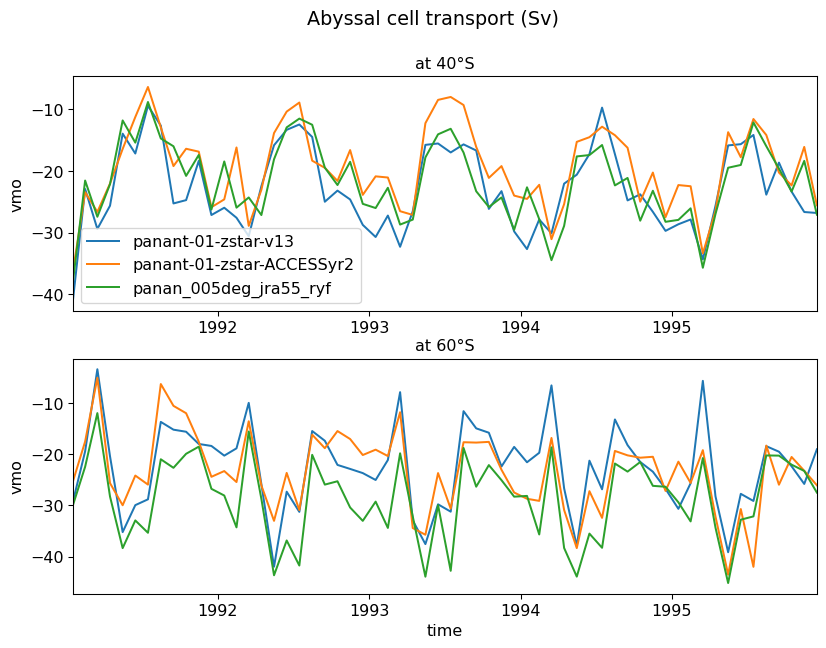

In [18]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'].sel(time=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('at 40°S')
plt.xlabel('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'].sel(time=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('at 60°S')

plt.suptitle('Abyssal cell transport (Sv)')
plt.show()

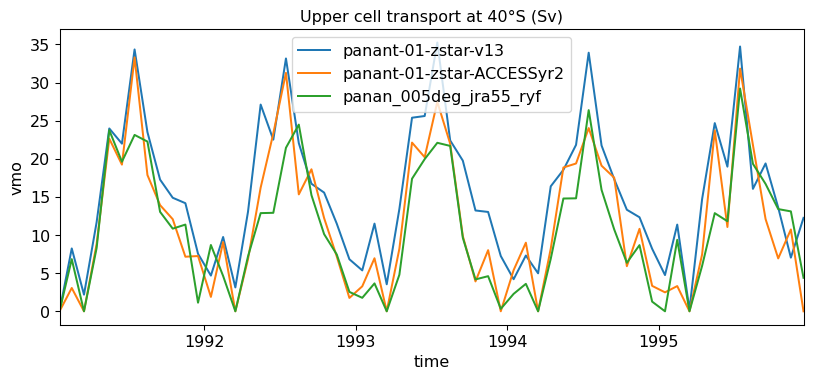

In [21]:
fig = plt.figure(figsize=(10, 4))

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_upper_40S'].plot(
        label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title('Upper cell transport at 40°S (Sv)')

plt.show()